In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import re
import os
import time
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
from bs4 import BeautifulSoup
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras import layers
from gensim.models import Word2Vec, Phrases
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Bidirectional, Dropout, Flatten, Input, Conv2D, Lambda, Reshape, Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image as image_keras
from tensorflow.keras import backend as K
from scipy.stats import norm

# NLP Sentiment Analysis

In [2]:
df = pd.read_csv('./datasets/IMDB Dataset.csv')
df.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

**Cleaning**

In [5]:
pattern = r'[^a-zA-z0-9\s]'

df.review = df.review.apply(lambda s: s.lower())
df.review = df.review.apply(lambda s: BeautifulSoup(s).get_text())
df.review = df.review.apply(lambda s: re.sub(pattern, '', s))

**Tokenize, lemmatize**

In [6]:
stopwords = nltk.corpus.stopwords.words('english')

df["review_tokens"] = df.review.apply(lambda s: nltk.word_tokenize(s))
df.review_tokens = df.review_tokens.apply(lambda s: [w for w in s if w not in stopwords])

In [7]:
lemmatizer = nltk.stem.WordNetLemmatizer()
df['review_lemm'] = df.review_tokens.apply(lambda s: [lemmatizer.lemmatize(w) for w in s])

df.head()

review sentiment  \
0  one of the other reviewers has mentioned that ...  positive   
1  a wonderful little production the filming tech...  positive   
2  i thought this was a wonderful way to spend ti...  positive   
3  basically theres a family where a little boy j...  negative   
4  petter matteis love in the time of money is a ...  positive   

                                       review_tokens  \
0  [one, reviewers, mentioned, watching, 1, oz, e...   
1  [wonderful, little, production, filming, techn...   
2  [thought, wonderful, way, spend, time, hot, su...   
3  [basically, theres, family, little, boy, jake,...   
4  [petter, matteis, love, time, money, visually,...   

                                         review_lemm  
0  [one, reviewer, mentioned, watching, 1, oz, ep...  
1  [wonderful, little, production, filming, techn...  
2  [thought, wonderful, way, spend, time, hot, su...  
3  [basically, there, family, little, boy, jake, ...  
4  [petter, matteis, love, time, money, visually,...

**Word2Vec**

In [8]:
bigrams = Phrases(sentences=df.review_lemm)
trigrams = Phrases(sentences=bigrams[df.review_lemm])

In [9]:
%%time

embedding_vector_size = 256

word2vec_model = Word2Vec(
    sentences = trigrams[bigrams[df.review_lemm]],
    vector_size = embedding_vector_size,
    min_count=3, window=5, workers=4)

word2vec_model.save("word2vec.model")

Wall time: 2min 49s


**Sentiment**

In [10]:
lb = LabelBinarizer()
sentiment = lb.fit_transform(df.sentiment)

In [11]:
keys = list(word2vec_model.wv.key_to_index.keys())
filter_none = lambda w: word2vec_model.wv.key_to_index.get(w, None) is not None
encode = lambda r: list(map(keys.index, filter(filter_none, r)))

In [12]:
input_length = 150

In [13]:
%%time
padded = pad_sequences(
    sequences = list(map(encode, trigrams[bigrams[df.review_lemm]])),
    maxlen = input_length,
    padding = 'pre')

Wall time: 28min 27s


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    padded,
    sentiment,
    test_size=0.2,
    shuffle=True)

In [23]:
model = Sequential()

model.add(layers.Embedding(
    input_dim = word2vec_model.wv.vectors.shape[0],
    output_dim = word2vec_model.wv.vectors.shape[1], 
    input_length = input_length,
    weights = [word2vec_model.wv.vectors],
    trainable=False))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(Bidirectional(GRU(64)))
model.add(Dropout(0.3))
model.add(Dense(32))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 256)          20603648  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 150, 128)          123648    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               74496     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [24]:
model.compile(
    loss = "binary_crossentropy",
    optimizer = 'adam',
    metrics = ['accuracy'])

In [25]:
batch_size = 32
epochs = 10

In [28]:
earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=batch_size,
    epochs=epochs)

Epoch 1/10
1250/1250 [==============================] - 48s 31ms/step - loss: 0.4390 - accuracy: 0.7940 - val_loss: 0.3239 - val_accuracy: 0.8577
Epoch 2/10
1250/1250 [==============================] - 36s 29ms/step - loss: 0.2941 - accuracy: 0.8776 - val_loss: 0.2761 - val_accuracy: 0.8862
Epoch 3/10
1250/1250 [==============================] - 36s 28ms/step - loss: 0.2674 - accuracy: 0.8915 - val_loss: 0.2658 - val_accuracy: 0.8897
Epoch 4/10
1250/1250 [==============================] - 33s 27ms/step - loss: 0.2318 - accuracy: 0.9062 - val_loss: 0.2542 - val_accuracy: 0.8946
Epoch 5/10
1250/1250 [==============================] - 35s 28ms/step - loss: 0.2113 - accuracy: 0.9150 - val_loss: 0.2580 - val_accuracy: 0.8950
Epoch 6/10
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1771 - accuracy: 0.9313 - val_loss: 0.2731 - val_accuracy: 0.8920
Epoch 7/10
1250/1250 [==============================] - 37s 29ms/step - loss: 0.1479 - accuracy: 0.9455 - val_loss: 0.3003 -

In [70]:
def plot_val_loss(his):
    loss_values = his['loss']
    val_loss_values = his['val_loss']
    epochs = range(1, len(loss_values) + 1)

    line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
    line2 = plt.plot(epochs, loss_values, label='Training Loss')
    plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
    plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
    plt.xlabel('Epochs') 
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()
    
def plot_val_acc(his):
    acc_values = his['accuracy']
    acc_loss_values = his['val_accuracy']
    epochs = range(1, len(acc_values) + 1)

    line1 = plt.plot(epochs, acc_loss_values, label='Validation/Test Accuracy')
    line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
    plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
    plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
    plt.xlabel('Epochs') 
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

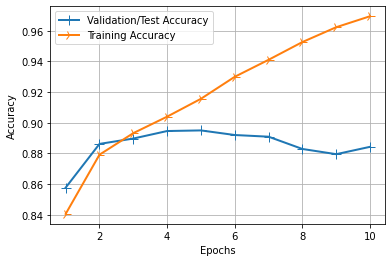

In [30]:
plot_val_acc(history.history)

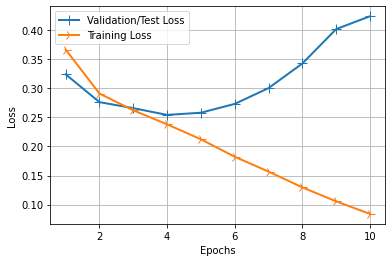

In [31]:
plot_val_loss(history.history)

In [32]:
loss, accuracy = model.evaluate(X_test, y_test)

313/313 [==============================] - 5s 15ms/step - loss: 0.4238 - accuracy: 0.8843


# MNIST Fashion GAN

In [33]:
(x_train, y_train), (x_test, y_test)  = fashion_mnist.load_data()

In [34]:
_0, _1, _2 = x_train.shape
x_train = x_train.reshape(_0, _1, _2, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5 # Normalize the images to [-1, 1]

print(x_train.shape)

(60000, 28, 28, 1)


In [35]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [36]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [37]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

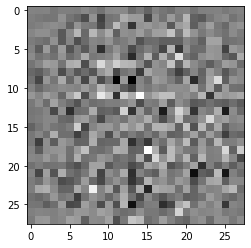

In [38]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [39]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [40]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00087237]], shape=(1, 1), dtype=float32)


In [41]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [42]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [43]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [44]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [45]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [46]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [47]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [48]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for img_batch in dataset:
            train_step(img_batch)

        generate_and_save_images(generator, epoch + 1, seed)
        
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        generate_and_save_images(generator, epochs, seed)

In [49]:
def generate_and_save_images(model, epoch, test_input):

    # Training set to false so that every layer runs in inferenc mode
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.show()

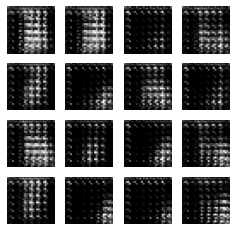

Time for epoch 1 is 12.142000913619995 sec


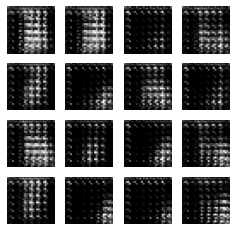

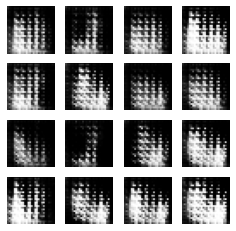

Time for epoch 2 is 7.598500967025757 sec


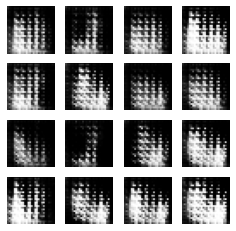

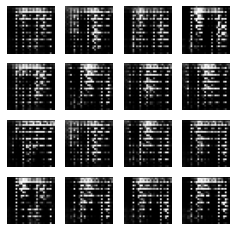

Time for epoch 3 is 7.991498708724976 sec


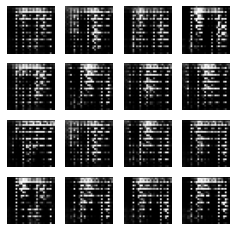

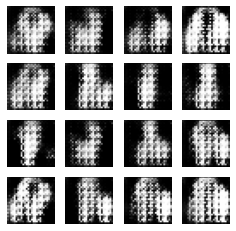

Time for epoch 4 is 7.615500450134277 sec


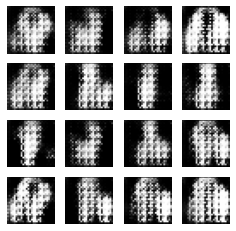

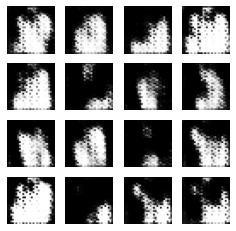

Time for epoch 5 is 7.666498899459839 sec


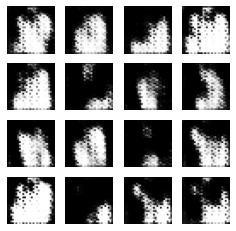

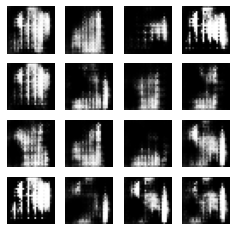

Time for epoch 6 is 8.788001775741577 sec


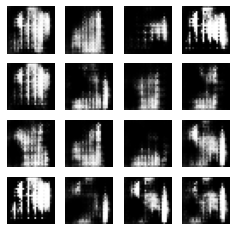

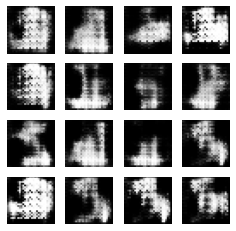

Time for epoch 7 is 7.904001235961914 sec


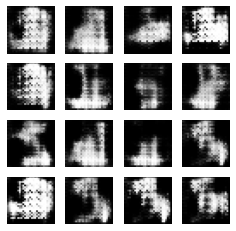

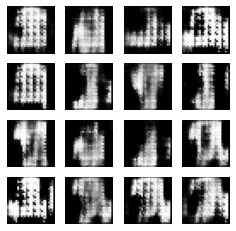

Time for epoch 8 is 8.092500686645508 sec


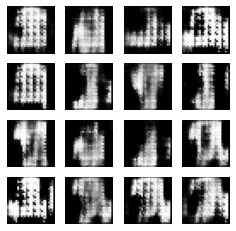

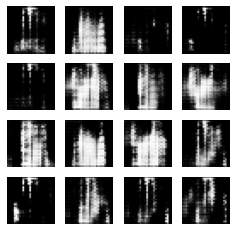

Time for epoch 9 is 7.936995983123779 sec


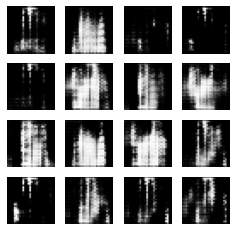

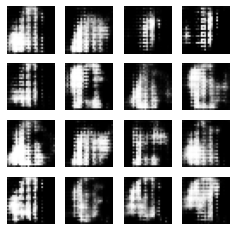

Time for epoch 10 is 7.9805006980896 sec


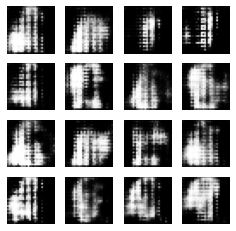

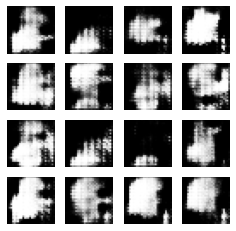

Time for epoch 11 is 8.038006782531738 sec


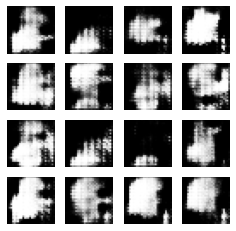

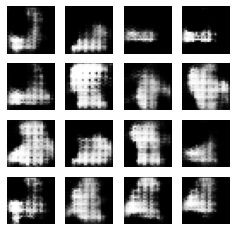

Time for epoch 12 is 8.455000877380371 sec


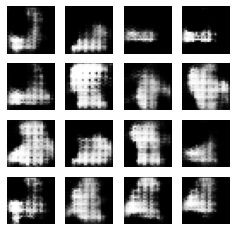

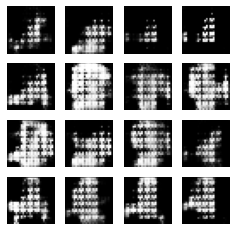

Time for epoch 13 is 8.170496940612793 sec


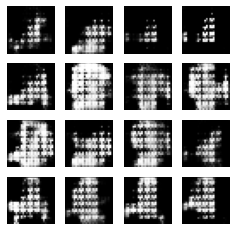

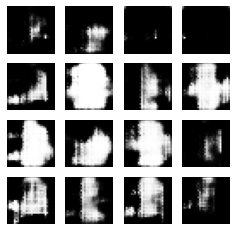

Time for epoch 14 is 7.943498849868774 sec


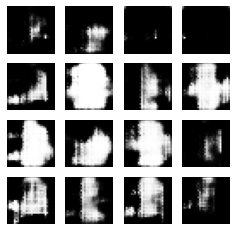

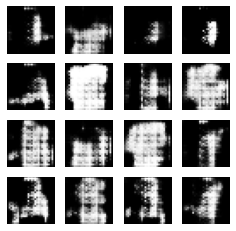

Time for epoch 15 is 7.989492893218994 sec


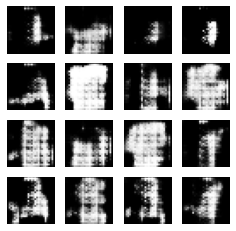

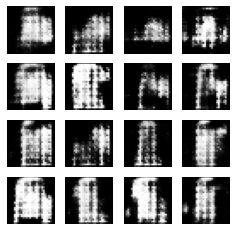

Time for epoch 16 is 7.942501068115234 sec


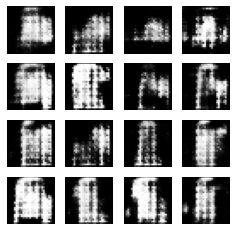

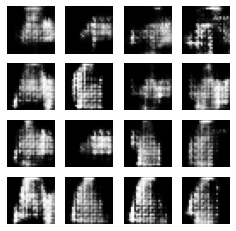

Time for epoch 17 is 9.26500129699707 sec


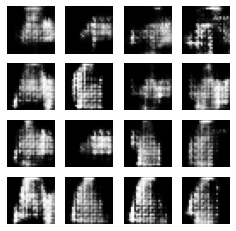

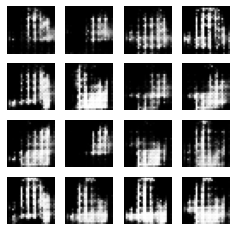

Time for epoch 18 is 8.148497104644775 sec


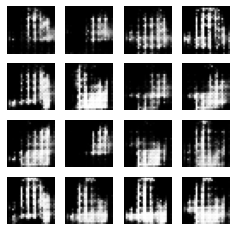

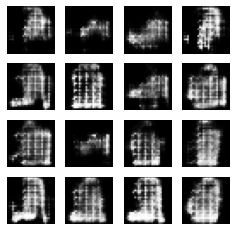

Time for epoch 19 is 8.01550030708313 sec


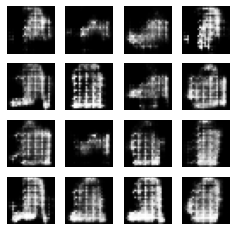

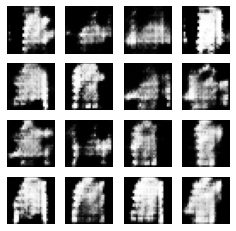

Time for epoch 20 is 7.9095001220703125 sec


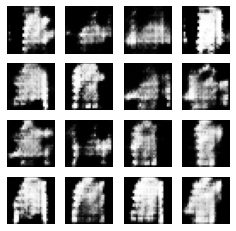

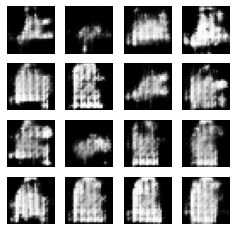

Time for epoch 21 is 7.902999639511108 sec


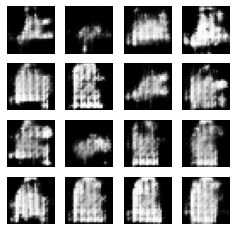

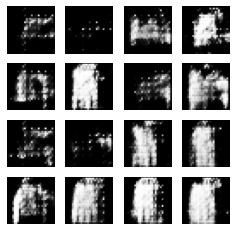

Time for epoch 22 is 9.190000772476196 sec


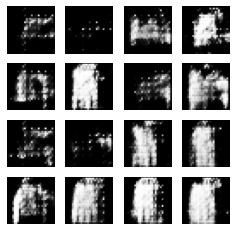

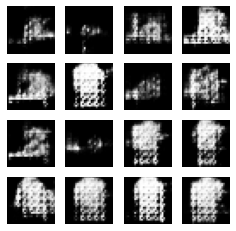

Time for epoch 23 is 8.147498846054077 sec


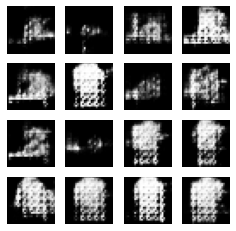

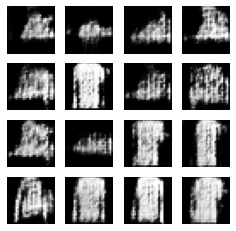

Time for epoch 24 is 8.241000890731812 sec


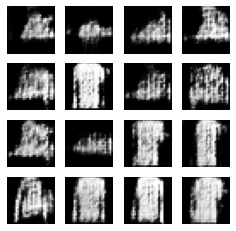

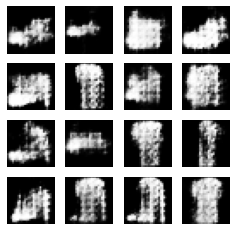

Time for epoch 25 is 8.05349850654602 sec


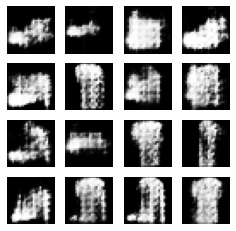

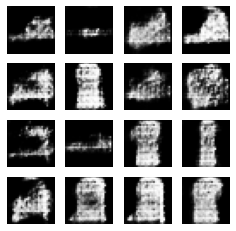

Time for epoch 26 is 8.00800347328186 sec


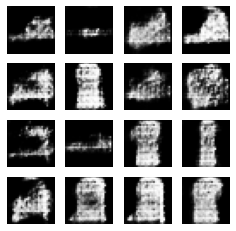

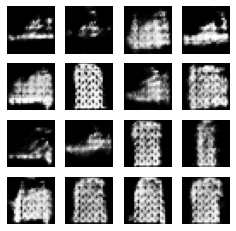

Time for epoch 27 is 8.050499200820923 sec


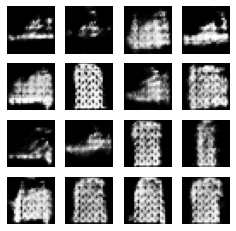

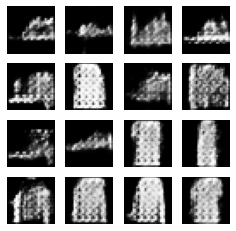

Time for epoch 28 is 8.01400113105774 sec


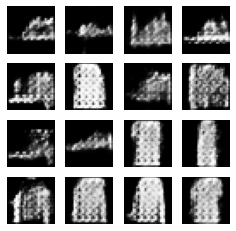

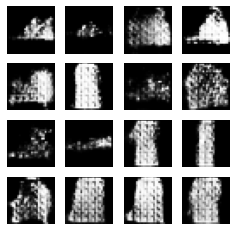

Time for epoch 29 is 8.011000156402588 sec


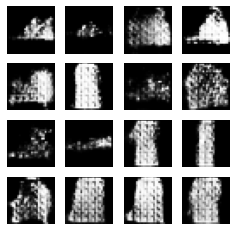

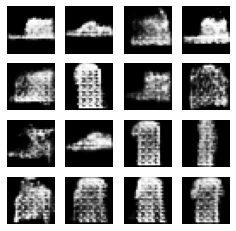

Time for epoch 30 is 8.039496660232544 sec


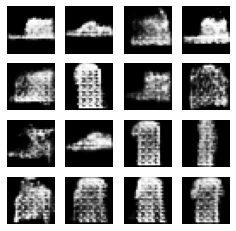

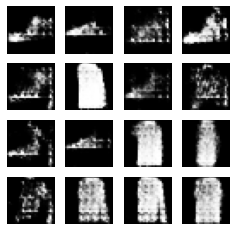

Time for epoch 31 is 8.116999864578247 sec


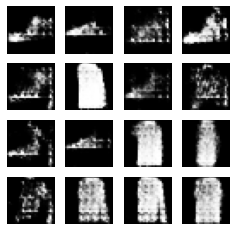

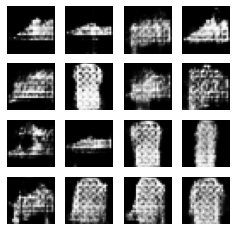

Time for epoch 32 is 7.738501787185669 sec


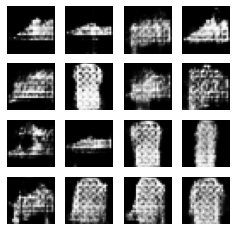

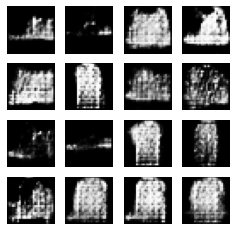

Time for epoch 33 is 8.63349986076355 sec


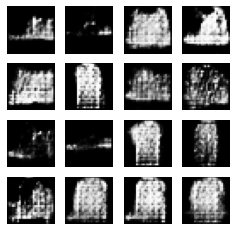

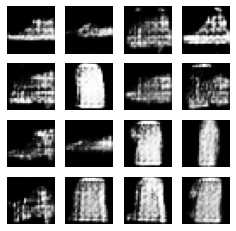

Time for epoch 34 is 7.652998924255371 sec


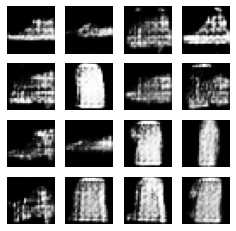

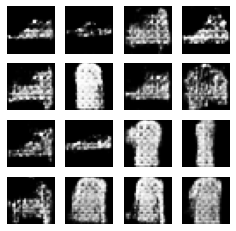

Time for epoch 35 is 7.825002193450928 sec


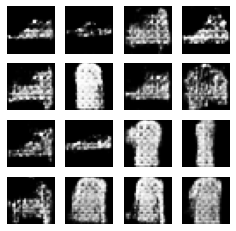

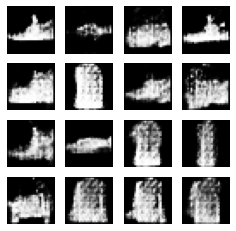

Time for epoch 36 is 7.735499620437622 sec


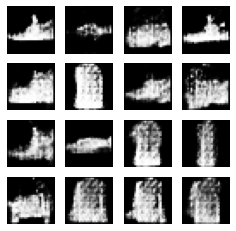

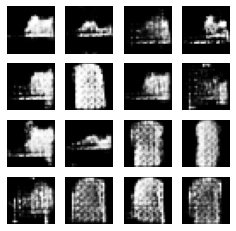

Time for epoch 37 is 7.8329994678497314 sec


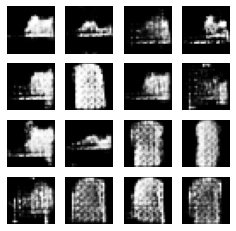

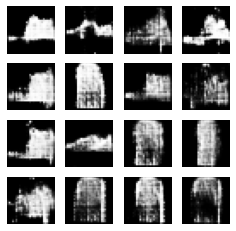

Time for epoch 38 is 7.796999931335449 sec


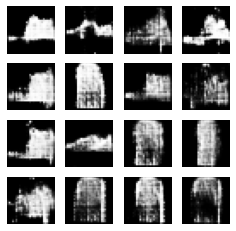

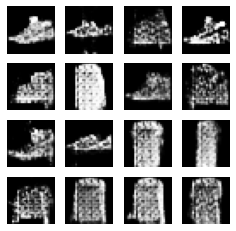

Time for epoch 39 is 7.823999881744385 sec


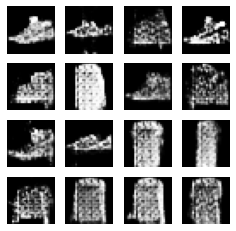

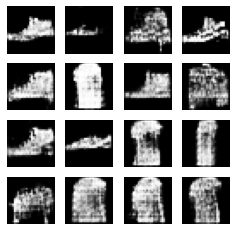

Time for epoch 40 is 7.73149847984314 sec


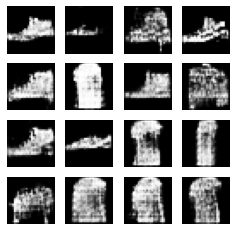

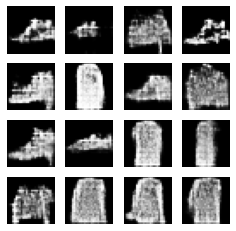

Time for epoch 41 is 7.748501300811768 sec


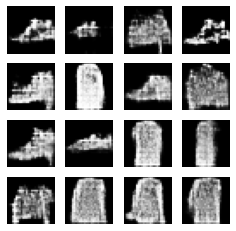

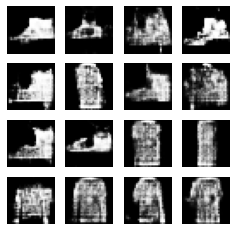

Time for epoch 42 is 7.752999305725098 sec


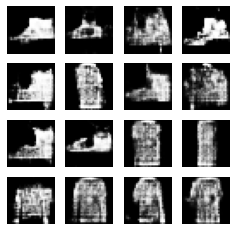

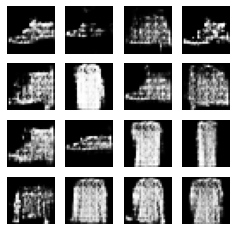

Time for epoch 43 is 7.594498872756958 sec


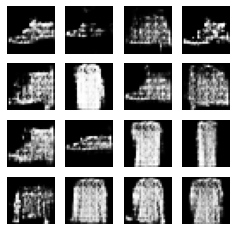

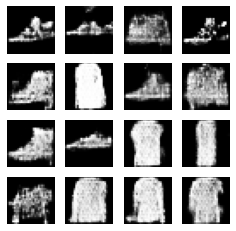

Time for epoch 44 is 7.65850043296814 sec


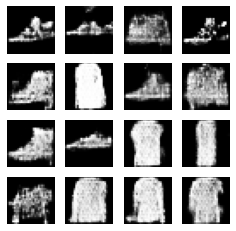

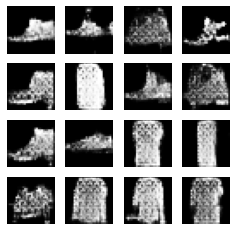

Time for epoch 45 is 7.735999822616577 sec


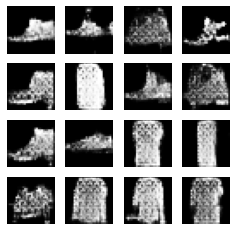

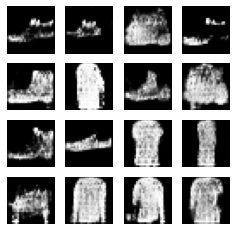

Time for epoch 46 is 7.788499116897583 sec


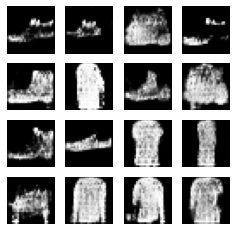

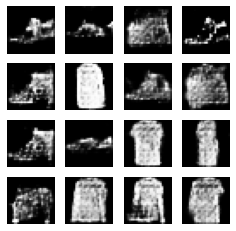

Time for epoch 47 is 7.670499801635742 sec


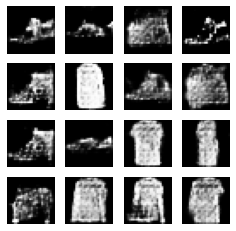

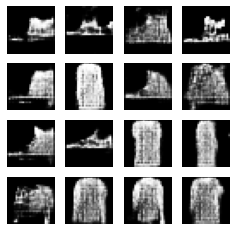

Time for epoch 48 is 7.904001474380493 sec


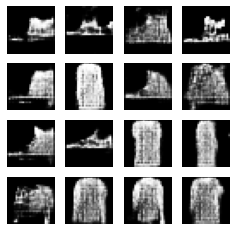

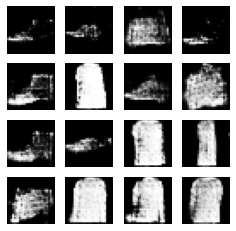

Time for epoch 49 is 8.883500099182129 sec


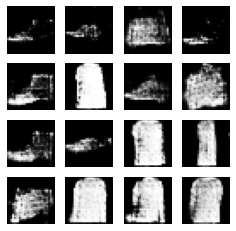

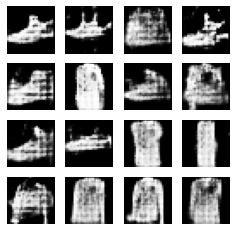

Time for epoch 50 is 7.525498867034912 sec


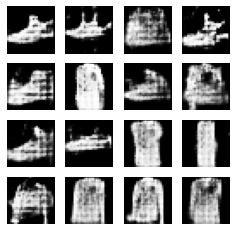

Wall time: 7min 13s


In [50]:
%%time
train(train_dataset, EPOCHS)

# CNN - VGG16 - Cats vs Dogs

In [62]:
input_shape = (224, 224, 3)
img_width = 224
img_height = 224

batch_size = 32
epochs = 50
lr = 1e-4

In [63]:
dataset_home = './datasets/cats_dogs'

In [64]:
datagen = image_keras.ImageDataGenerator(
    rescale=1./255.0, 
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range = 30,
    horizontal_flip=True)

train_gen = datagen.flow_from_directory(batch_size=batch_size,
                                                 directory=dataset_home,
                                                 shuffle=True,
                                                 target_size=(img_width, img_height), 
                                                 subset="training",
                                                 class_mode='binary')

validation_gen = datagen.flow_from_directory(batch_size=batch_size,
                                                 directory=dataset_home,
                                                 shuffle=True,
                                                 target_size=(img_width, img_height), 
                                                 subset="validation",
                                                 class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


In [65]:
vgg16 = VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = input_shape)
vgg16.trainable = False

In [66]:
layers = vgg16.output

transfer_model = Sequential([
    vgg16,
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

print(transfer_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)               3211392   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 129       
Total params: 17,926,209
Trainable params: 3,211,521
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [67]:
transfer_model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=lr),
              metrics=['accuracy'])

In [68]:
checkpoint = ModelCheckpoint("cats_dogs_transfer_model.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

transfer_history = transfer_model.fit(
    train_gen,
    steps_per_epoch = train_gen.samples // batch_size,
    epochs = epochs,
    callbacks = [earlystop, checkpoint],
    validation_data = validation_gen,
    validation_steps = validation_gen.samples // batch_size)

Epoch 1/50
556/625 [=========================>....] - ETA: 34s - loss: 0.3708 - accuracy: 0.8221

C:\Users\Konrad Ulman\AppData\Local\Programs\Python\Python38\lib\site-packages\PIL\TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
C:\Users\Konrad Ulman\AppData\Local\Programs\Python\Python38\lib\site-packages\PIL\TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
C:\Users\Konrad Ulman\AppData\Local\Programs\Python\Python38\lib\site-packages\PIL\TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
C:\Users\Konrad Ulman\AppData\Local\Programs\Python\Python38\lib\site-packages\PIL\TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
C:\Users\Konrad Ulman\AppData\Local\Programs\Python\Python38\lib\site-packages\PIL\TiffImagePlugin.

625/625 [==============================] - 396s 627ms/step - loss: 0.3624 - accuracy: 0.8272 - val_loss: 0.2378 - val_accuracy: 0.8946

Epoch 00001: val_loss improved from inf to 0.23782, saving model to cats_dogs_transfer_model.h5
Epoch 2/50
625/625 [==============================] - 292s 468ms/step - loss: 0.2246 - accuracy: 0.9068 - val_loss: 0.2206 - val_accuracy: 0.9105

Epoch 00002: val_loss improved from 0.23782 to 0.22063, saving model to cats_dogs_transfer_model.h5
Epoch 3/50
625/625 [==============================] - 283s 453ms/step - loss: 0.2013 - accuracy: 0.9158 - val_loss: 0.2012 - val_accuracy: 0.9171

Epoch 00003: val_loss improved from 0.22063 to 0.20119, saving model to cats_dogs_transfer_model.h5
Epoch 4/50
625/625 [==============================] - 273s 437ms/step - loss: 0.2009 - accuracy: 0.9159 - val_loss: 0.2037 - val_accuracy: 0.9129

Epoch 00004: val_loss did not improve from 0.20119
Epoch 5/50
625/625 [==============================] - 278s 445ms/step - loss

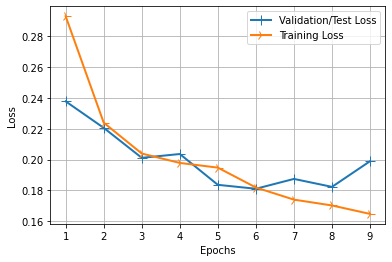

In [71]:
plot_val_loss(transfer_history.history)

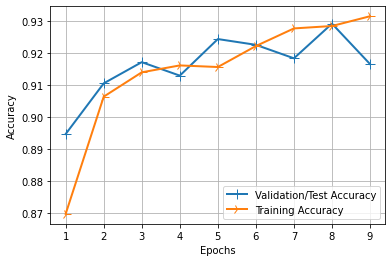

In [72]:
plot_val_acc(transfer_history.history)

### Predict with VGG16

In [73]:
def load_image(filename):

    im = image_keras.load_img(filename)
    plt.imshow(im)

    im = image_keras.load_img(filename, target_size=(img_width, img_height))
    
    im_tensor = image_keras.img_to_array(im)
    im_tensor = im_tensor / 255
    im_tensor = np.expand_dims(im_tensor, axis=0)
    
    return im_tensor

In [74]:
def get_prediction(img):
    cat_id = train_gen.class_indices['Cat']
    dog_id = train_gen.class_indices['Dog']
    im_id = (transfer_model.predict(img) > 0.5).astype("int32")[0][0]

    if im_id == cat_id: return 'Cat'
    if im_id == dog_id: return 'Dog'

    return '-1'

'Dog'

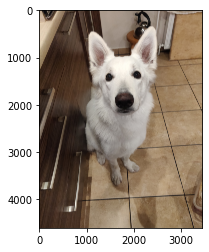

In [75]:
dog = load_image('./example_image/1.jpg')
get_prediction(dog)

'Cat'

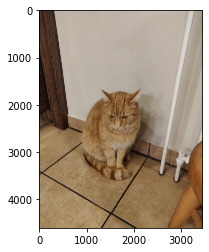

In [76]:
cat = load_image('./example_image/2.jpg')
get_prediction(cat)

# MNIST VAE - Variatonal Autoencoder

In [77]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [78]:
x_train = x_train / 255.0
x_test = x_test / 255.0

n, x, y = x_train.shape
x_train = x_train.reshape((n, x * y))
print(x_train.shape)

n, x, y = x_test.shape
x_test = x_test.reshape((n, x * y))
print(x_test.shape)

(60000, 784)
(10000, 784)


**Sampling layer**

In [79]:
def sampling(args):
    mu, log_var, batches, dim = args
    eps = tf.keras.backend.random_normal(shape=(batches, dim), mean=0., stddev=1.0)
    return mu + tf.exp(log_var) * eps

**Encoder**

In [85]:
latent_dim = 2
n_hidden = 256
batch_size = 100
epochs = 50

In [86]:
x = Input(shape=(x_train.shape[1:]))
x_encoded = Dense(n_hidden, activation='relu')(x)
x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)

mu = Dense(latent_dim)(x_encoded)
log_var = Dense(latent_dim)(x_encoded)

z = Lambda(sampling, output_shape=(latent_dim,))([mu, log_var, batch_size, latent_dim])

**Decoder**

In [87]:
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_train.shape[1], activation='sigmoid')

z_decoded = z_decoder1(z)
z_decoded = z_decoder2(z_decoded)
y = y_decoder(z_decoded)

**VAE**

In [88]:
# loss
reconstruction_loss = tf.keras.metrics.binary_crossentropy(x, y) * x_train.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
vae_loss = reconstruction_loss + kl_loss

vae = Model(x, y)

vae.add_loss(vae_loss)
vae.compile(optimizer=Adam())

vae.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_44 (Dense)                (None, 256)          200960      input_12[0][0]                   
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 128)          32896       dense_44[0][0]                   
__________________________________________________________________________________________________
dense_46 (Dense)                (None, 2)            258         dense_45[0][0]                   
___________________________________________________________________________________________

In [89]:
vae_history = vae.fit(x_train,
       shuffle=True,
       epochs=epochs,
       batch_size=batch_size,
       validation_data=(x_test, None), verbose=1)

Epoch 1/50
600/600 [==============================] - 4s 6ms/step - loss: 234.0819 - val_loss: 174.2017
Epoch 2/50
600/600 [==============================] - 3s 4ms/step - loss: 172.5415 - val_loss: 165.7741
Epoch 3/50
600/600 [==============================] - 3s 4ms/step - loss: 164.5718 - val_loss: 158.9970
Epoch 4/50
600/600 [==============================] - 3s 5ms/step - loss: 157.8359 - val_loss: 154.5943
Epoch 5/50
600/600 [==============================] - 3s 4ms/step - loss: 153.4902 - val_loss: 151.6151
Epoch 6/50
600/600 [==============================] - 3s 5ms/step - loss: 151.2561 - val_loss: 149.4491
Epoch 7/50
600/600 [==============================] - 3s 5ms/step - loss: 149.1720 - val_loss: 147.8988
Epoch 8/50
600/600 [==============================] - 3s 5ms/step - loss: 147.7727 - val_loss: 146.7655
Epoch 9/50
600/600 [==============================] - 3s 5ms/step - loss: 145.9726 - val_loss: 145.6625
Epoch 10/50
600/600 [==============================] - 3s 5ms/st

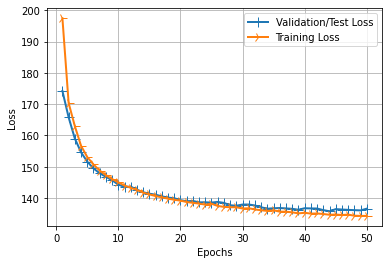

In [93]:
plot_val_loss(vae_history.history)

### Display how the latent space clusters different digit classes

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_44 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_45 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_46 (Dense)             (None, 2)                 258       
Total params: 234,114
Trainable params: 234,114
Non-trainable params: 0
_________________________________________________________________


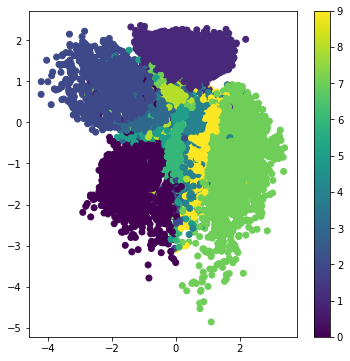

In [94]:
# build encoder
encoder = Model(x, mu)
encoder.summary()

# Plot of the digit classes in the latent space
x_train_latent = encoder.predict(x_train, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_train_latent[:, 0], x_train_latent[:, 1], c=y_train)
plt.colorbar()
plt.show()

### Display a grid of sampled digits

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_48 (Dense)             multiple                  384       
_________________________________________________________________
dense_49 (Dense)             multiple                  33024     
_________________________________________________________________
dense_50 (Dense)             multiple                  201488    
Total params: 234,896
Trainable params: 234,896
Non-trainable params: 0
_________________________________________________________________


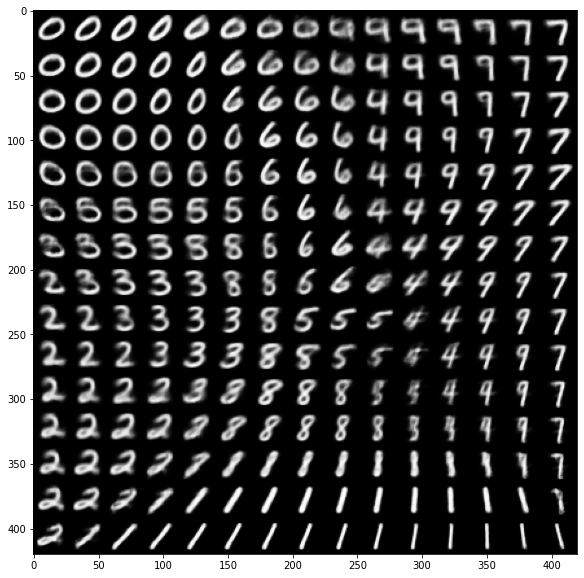

In [95]:
# build decoder
decoder_input = Input(shape=(latent_dim,))
_z_decoded = z_decoder1(decoder_input)
_z_decoded = z_decoder2(_z_decoded)
_y = y_decoder(_z_decoded)
generator = Model(decoder_input, _y)
generator.summary()

# display a 2D manifold of the digits
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()